# Risk‑Aware Drainage Optimisation – Demo Notebook
This notebook illustrates how to:
1. **Load** a sample drainage network.
2. **Build** its QUBO/Ising encoding using `flow_qubo.py`.
3. **Solve** the optimisation problem (exact eigensolver).
4. **Visualise** the resulting flows with colour‑coded utilisation.

## 1.  Motivation & High-Level Goal
Flood-vulnerable cities in the MENA region already see **70 % of their population** living in at-risk urban areas.  
Our idea is to **dynamically re-route storm-water / wastewater** through existing pipe networks so that

* overall throughput is maximised,  
* energy consumption stays below an operational budget, and  
* the flow avoids high-risk zones (low elevation, old infrastructure, steep topography).

Classically this is a *constrained network-flow* problem.  
We demonstrate how the same task can be mapped to a **QUBO / Ising Hamiltonian** and explored on near-term quantum optimisers such as QAOA or D-Wave annealers.

In [1]:
# !pip install networkx matplotlib docplex "qiskit-optimization>=0.6" qiskit_algorithms qiskit<2.0

import json, networkx as nx
from pathlib import Path
from flow_qubo import build_qubo, solve_qp, flows_from_result, draw_solution


## 2.  Formal Problem Statement

| Symbol | Meaning |
|--------|---------|
| $G=(V,E)$ | directed graph of pipes |
| $c_i$ | capacity (m³ s⁻¹) of node $i$ |
| $r_i\in[0,1]$ | risk score of node $i$ |
| $e_{ij}$ | capacity of pipe $i\!\to\!j$ |
| $I_{ij}$ | kWh per m³ to pump along $i\!\to\!j$ |
| $f_{ij}$ | **decision variable** – flow on $i\!\to\!j$ |

In [2]:
# Sample input configuration
config = {
    "edges": [["S", "A"], ["A", "B"], ["B", "T"], ["A", "T"]],
    "node_capacity": {"S": 5, "A": 4, "B": 4, "T": 6},
    "node_risk": {"S": 0.1, "A": 0.3, "B": 0.2, "T": 0.05},
    "pipe_capacity": {"S,A": 3, "A,B": 2, "B,T": 3, "A,T": 1},
    "energy_cost": {"S,A": 1.2, "A,B": 1.5, "B,T": 1.1, "A,T": 1.8},
    "bits": 2,
    "delta": 0.5,
    "lambda": 0.4,
    "energy_budget": 4,
}

### 2.1 Hard Constraints
$$
\begin{aligned}
&\sum_{k:(k,i)\in E} f_{ki} \le c_i &\quad&\text{(node inflow)}\\
&\sum_{j:(i,j)\in E} f_{ij} \le c_i &&\text{(node outflow)}\\
&0 \le f_{ij} \le e_{ij} &&\text{(pipe capacity)}\\[4pt]
&\sum_{(i,j)\in E} I_{ij}\,f_{ij} \;\le\; E_{\text{limit}} &&\text{(energy budget)}
\end{aligned}
$$

### 2.2 Risk-Aware Objective
$$
\text{Throughput }F=\sum_{(i,j)} f_{ij},\qquad \\
\text{Risk }R=\frac12\sum_{(i,j)} (r_i+r_j)f_{ij}.
$$

$$
\boxed{\max_{f} F - \lambda R}
\qquad(\lambda\ge0\text{ tunes risk-aversion}).
$$

## 3.  Network Flow to QUBO

1. **Binary expansion:** $f_{ij} = \Delta\sum_{k=0}^{b-1} 2^k\,x_{ij}^{(k)},\;x_{ij}^{(k)}\in\{0,1\}$.
2. **Quadratic penalties:** turn every hard constraint into squared penalty terms.
3. Result: an *unconstrained* quadratic objective  
   $$
   \mathcal L(x)=\tfrac12 x^\top Q x + q^\top x + \text{const}.
   $$
4. Feed $Q, q$ to **QAOA** (gate-based) or **quantum annealing** (D-Wave).

Our helper module `flow_qubo.py` automates steps 1–3, and provides functionality for using QAOA (step 4).


## 4.  Software Pipeline

1. **JSON → NetworkX**: load graph & parameters  
2. **`build_qubo()`**: construct Docplex model, export to `QuadraticProgram`  
3. **`solve_qp()`**: choose backend
   * `exact` – NumPy eigensolver (≤20 qubits, ground truth)  
   * `qaoa` – 2-layer QAOA + COBYLA optimiser  
4. **`flows_from_result()`**: decode binary solution back to physical flows  
5. **`draw_solution()`**:  
   * node colour = utilisation = inflow / capacity  
   * edge thickness & colour = flow / pipe capacity  

All five steps run in a dozen lines (see code cells).


Info: Using indexed variables mapping
Mapped x0 (value=1.0) to x_S_A_0: edge=('S', 'A'), weight=0.5
Mapped x1 (value=1.0) to x_S_A_1: edge=('S', 'A'), weight=1.0
Mapped x2 (value=1.0) to x_A_B_0: edge=('A', 'B'), weight=0.5
Mapped x3 (value=1.0) to x_A_B_1: edge=('A', 'B'), weight=1.0
Mapped x5 (value=1.0) to x_A_T_1: edge=('A', 'T'), weight=1.0
Mapped x6 (value=1.0) to x_B_T_0: edge=('B', 'T'), weight=0.5
Mapped x7 (value=1.0) to x_B_T_1: edge=('B', 'T'), weight=1.0
Objective value: 982.915
A -> B : 1.5 m³/s
A -> T : 1.0 m³/s
B -> T : 1.5 m³/s
S -> A : 1.5 m³/s


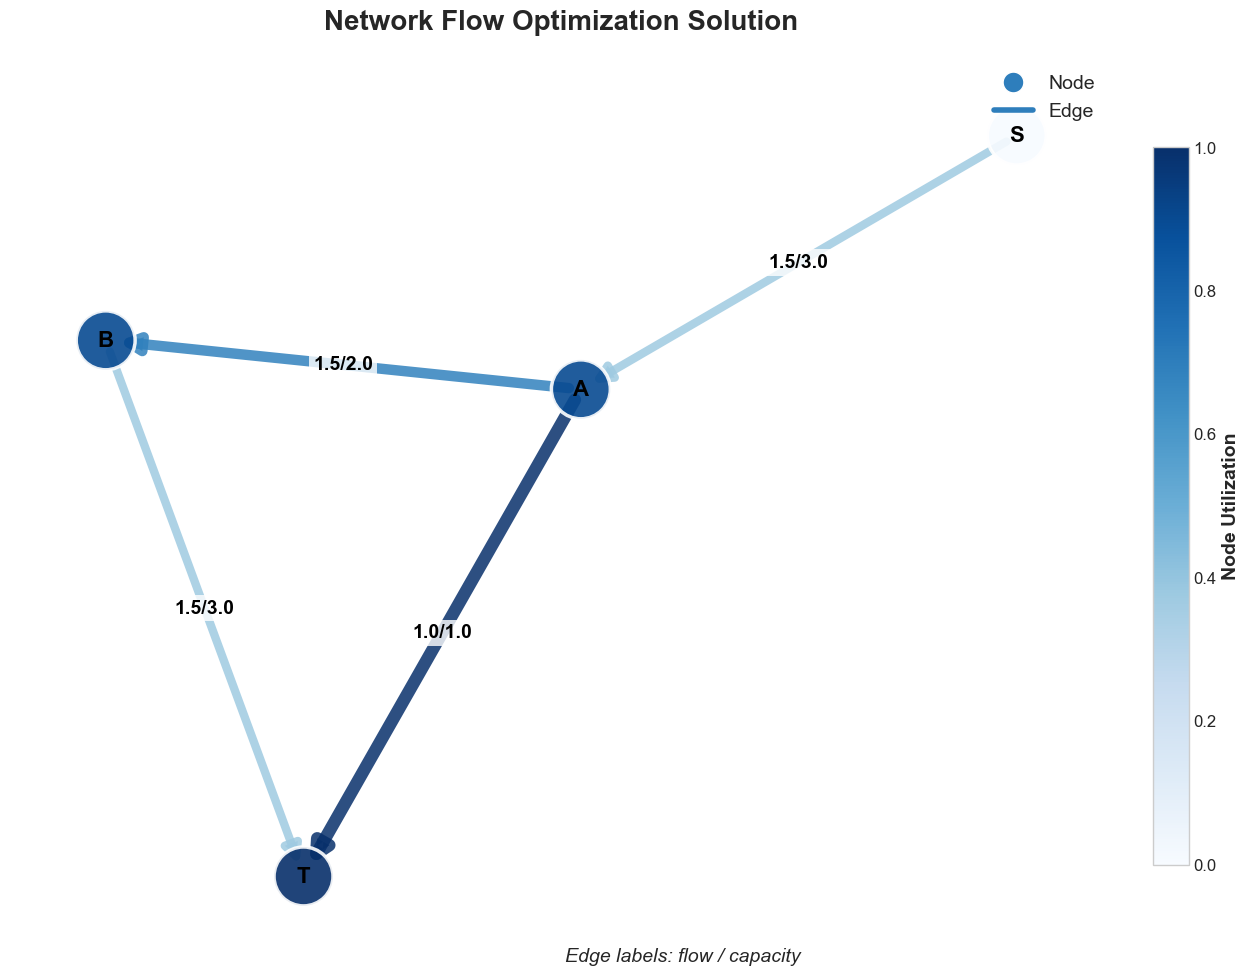

In [3]:
# Helper to convert string keys like "S,A" into tuple keys
def tuple_keys(d):
    return {tuple(k.split(',')): v for k, v in d.items()} if all(isinstance(k, str) for k in d) else d

G = nx.DiGraph(config["edges"])

qp, vmap = build_qubo(
    G,
    config["node_capacity"],
    config["node_risk"],
    tuple_keys(config["pipe_capacity"]),
    tuple_keys(config["energy_cost"]),
    bits_per_edge=config["bits"],
    flow_quantum=config["delta"],
    λ=config["lambda"],
    energy_budget=config["energy_budget"],
)

# Solve exactly (good for ≤20 qubits)
result = solve_qp(qp, method="exact")
flows = flows_from_result(result, vmap)

print(f"Objective value: {result.fval:.3f}")
for e, f in sorted(flows.items()):
    print(f"{e[0]} -> {e[1]} : {f} m³/s")

draw_solution(G, flows, config["node_capacity"], tuple_keys(config["pipe_capacity"]))


Info: Using indexed variables mapping
Mapped x0 (value=1.0) to x_N1_N2_0: edge=('N1', 'N2'), weight=2.5
Mapped x1 (value=1.0) to x_N1_N2_1: edge=('N1', 'N2'), weight=5.0
Mapped x3 (value=1.0) to x_N2_N3_1: edge=('N2', 'N3'), weight=5.0
Mapped x4 (value=1.0) to x_N2_N5_0: edge=('N2', 'N5'), weight=2.5
Mapped x7 (value=1.0) to x_N3_N6_1: edge=('N3', 'N6'), weight=5.0
Mapped x8 (value=1.0) to x_N4_N5_0: edge=('N4', 'N5'), weight=2.5
Mapped x9 (value=1.0) to x_N4_N5_1: edge=('N4', 'N5'), weight=5.0
Mapped x11 (value=1.0) to x_N5_N6_1: edge=('N5', 'N6'), weight=5.0
Mapped x13 (value=1.0) to x_N5_N7_1: edge=('N5', 'N7'), weight=5.0
Mapped x15 (value=1.0) to x_N6_N7_1: edge=('N6', 'N7'), weight=5.0
Objective = 6088.575
Edge        flow
N1->N2   7.5
N2->N3   5.0
N2->N5   2.5
N3->N6   5.0
N4->N5   7.5
N5->N6   5.0
N5->N7   5.0
N6->N7   5.0


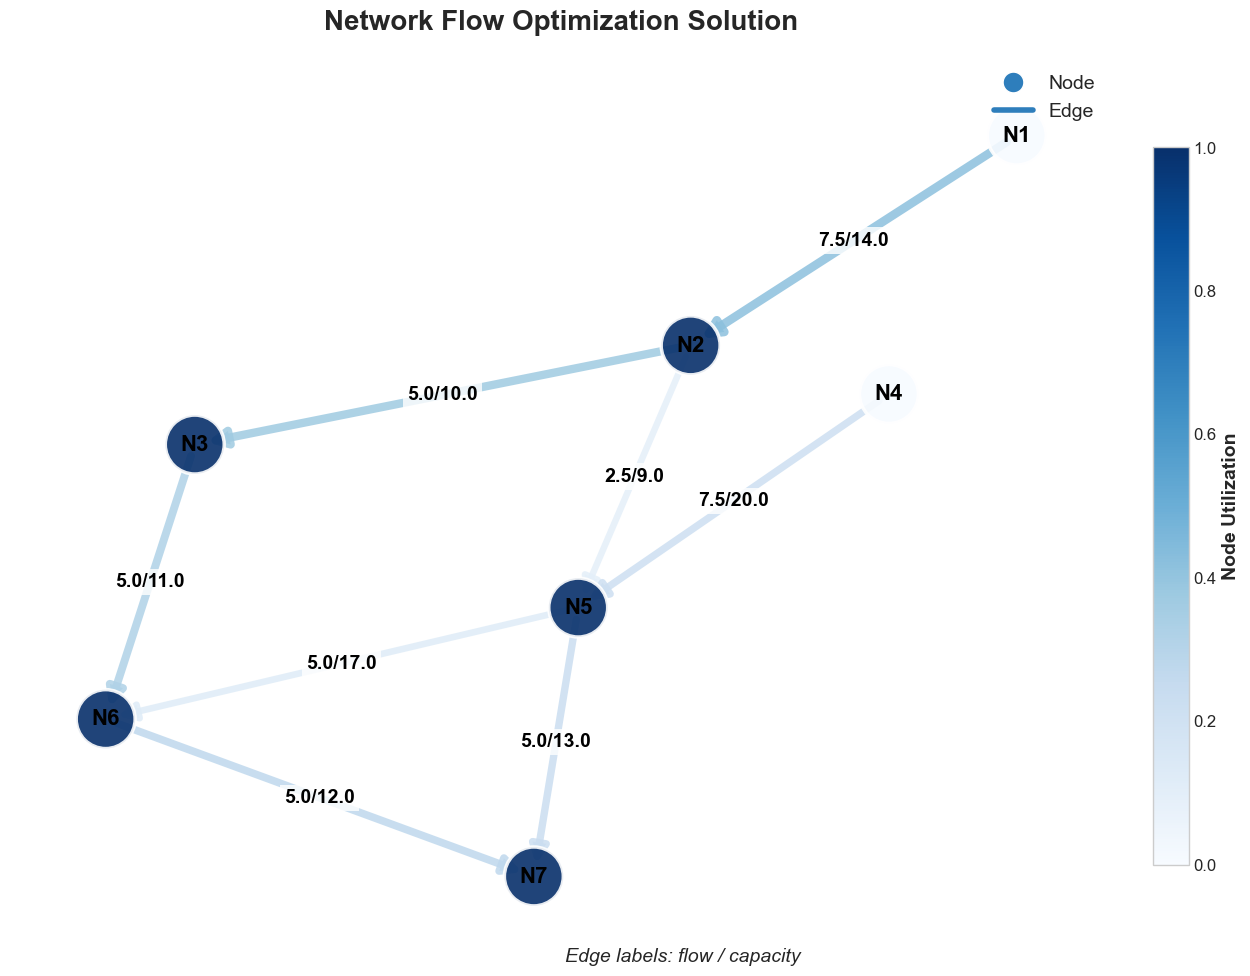

In [4]:
data = json.loads(Path('dubai.json').read_text())
# pipe_capacity = {tuple(key): val for key, val in data["pipe_capacity"].items()}
data['pipe_capacity'] = {tuple(key.split(',')): val for key, val in data["pipe_capacity"].items()}
data['energy_cost'] = {tuple(key.split(',')): val for key, val in data["energy_cost"].items()}
G = nx.DiGraph(data["edges"]) if nx else data["edges"]

qp, vmap = build_qubo(
    G,
    data["node_capacity"],
    data["node_risk"],
    data["pipe_capacity"],
    data["energy_cost"],
    bits_per_edge=data.get("bits", 3),
    flow_quantum=data.get("delta", 1.0),
    λ=data.get("lambda", 0.5),
    energy_budget=data.get("energy_budget"),
)

res = solve_qp(qp, "qaoa")
flows = flows_from_result(res, vmap)
print(f"Objective = {res.fval:.3f}\nEdge        flow")
for e, f in sorted(flows.items()):
    print(f"{e[0]}->{e[1]:<4} {f}")

draw_solution(G, flows, data["node_capacity"], tuple_keys(data["pipe_capacity"]))
